# Lab 4
## More Data Scraping and EDA

In this lab, you will improve your skills in scraping data from web pages, organizing the data in a desired format, and performing EDA.

For this lab, we are reusing code from Harvard's CS109: https://github.com/cs109/2015/blob/master/Lectures/02-DataScrapingQuizzes.ipynb

## Lab3.A. Run code for scraping Indeed.com data

You firs task will be to exectute the following blocks of code and try to understand what is happening after each line of the code. You will have to answer several questions to show your understanding.

Let us start with importing of the relevant packages.

In [7]:
import urllib2
import bs4 #this is beautiful soup

import time
from pandas import Series
import pandas as pd
from pandas import DataFrame
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

As you see, you imported the package called `re`, which supports regular expression operations. You have already used the other packages. 

The following block will access and load the contents of an Indeed.com web page. It will probably give you a warning -- please ignore it.

In [9]:
# Fixed url for job postings containing data scientist
url = 'http://www.indeed.com/jobs?q=data+scientist&l='
# read the website
source = urllib2.urlopen(url).read()
# parse html code
bs_tree = bs4.BeautifulSoup(source)
print bs_tree

C:\Users\Samuel\Anaconda2\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file C:\Users\Samuel\Anaconda2\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


<!DOCTYPE html>
<html lang="en">
<head>
<meta content="text/html;charset=utf-8" http-equiv="content-type"/>
<script src="/s/d8ca20f/en_US.js" type="text/javascript"></script>
<link href="/s/ecdfb5e/jobsearch_all.css" rel="stylesheet" type="text/css"/>
<link href="http://rss.indeed.com/rss?q=data+scientist" rel="alternate" title="Data Scientist Jobs, Employment" type="application/rss+xml"/>
<link href="/m/jobs?q=data+scientist" media="only screen and (max-width: 640px)" rel="alternate"/>
<link href="/m/jobs?q=data+scientist" media="handheld" rel="alternate"/>
<script type="text/javascript">
    
    if (typeof window['closureReadyCallbacks'] == 'undefined') {
        window['closureReadyCallbacks'] = [];
    }

    function call_when_jsall_loaded(cb) {
        if (window['closureReady']) {
            cb();
        } else {
            window['closureReadyCallbacks'].push(cb);
        }
    }
</script>
<meta content="1" name="ppstriptst"/>
<script src="/s/d53fa03/jobsearch-all-compiled.

** Question 1**:
 * What kind of page did you land on? Explain in a few sentences what is the content of this page.
 * What does the "?" and "&" in the url mean?
 * Explore the content of the web page. If you are using Firefox, open the page Inspector to understand how the underlying html code relates to the displayed content.
 * What pieces of the html code are responsible for showing the job title, company name, and job location?
 
The following block of code will figure out how many job ads are there for jobs that contain "data scientist' in the job title.

**Answer**:
* It is a page of job posting for data science roles.
* The question mark is a query string to pass parameter of key value pair to the server. The ampersand is to append another key value pair to the query.
* The job title is in an anchor (a) tag with class "jobtitle TurnstileLink". Underneath the title is a div tag with class "sjc1". In that tag is the company name and location, both in span tags with class "company" and "location". All of these attributes are in the div tag for the actual job with a unique id.


In [10]:
# see how many job postings we found
job_count_string = bs_tree.find(id = 'searchCount').contents[0]
job_count_string = job_count_string.split()[-2]
print("Search yielded %s hits." % (job_count_string))

# not that job_count so far is still a string, 
# not an integer, and the , separator prevents 
# us from just casting it to int

job_count_digits = [int(d) for d in job_count_string if d.isdigit()]
job_count = np.sum([digit*(10**exponent) for digit, exponent in 
                    zip(job_count_digits[::-1], range(len(job_count_digits)))])

print job_count

Search yielded 24,731 hits.
24731


** Question 2**:
* What does the "find(id = 'searchCount')" in the first line mean?
* What does the second line do?

**Question 3**: 
* Write a piece of code that finds the Salary Estimate object on the page

The following piece of code allows you to find the links to all the job ads on the page.

**Question 2 Answer**:
* The find() command returns the entire div tag where the id is "searchCount" and then parses it for only the text within the tag
* The second line tokenizes the string by spaces into a list of strings, where each string is a word from the text contained in the div tag. It then selects the second to last string, the count.

In [11]:
#Question 3 Answer
salary_est = bs_tree.find(id = 'rb_Salary Estimate')
print salary_est

<div class="rbSection rbOpen" id="rb_Salary Estimate">
<div class="rbHeader">
<span aria-level="3" class="ws_bold" role="heading">
                    Salary Estimate</span>
</div>
<div class="rbsrbo" id="SALARY_rbo">
<ul class="rbList">
<li onmousedown="rbptk('rb', 'salest', '1');">
<a href="/q-data-scientist-$55,000-jobs.html" rel="nofollow" title="$55,000 (19994)">$55,000</a> (19994)</li>
<li onmousedown="rbptk('rb', 'salest', '2');">
<a href="/q-data-scientist-$75,000-jobs.html" rel="nofollow" title="$75,000 (15957)">$75,000</a> (15957)</li>
<li onmousedown="rbptk('rb', 'salest', '3');">
<a href="/q-data-scientist-$95,000-jobs.html" rel="nofollow" title="$95,000 (11712)">$95,000</a> (11712)</li>
<li onmousedown="rbptk('rb', 'salest', '4');">
<a href="/q-data-scientist-$110,000-jobs.html" rel="nofollow" title="$110,000 (8208)">$110,000</a> (8208)</li>
<li onmousedown="rbptk('rb', 'salest', '5');">
<a href="/q-data-scientist-$130,000-jobs.html" rel="nofollow" title="$130,000 (4235)">

In [12]:
# The website is only listing 10 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []
for i in range(1): #do range(num_pages) if you want them all
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    html_page = urllib2.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')
    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if not jp.get('class') is None 
                    and ''.join(jp.get('class')) =="rowresult"]
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    # go after each link
    for id in job_ids:
        job_links.append(base_url + '/rc/clk?jk=' + id)
    print job_links
    time.sleep(1)

print "We found a lot of jobs: ", len(job_links)

['http://www.indeed.com/rc/clk?jk=9440c82f6d74acba', 'http://www.indeed.com/rc/clk?jk=344df9ea2a94585b', 'http://www.indeed.com/rc/clk?jk=8e58b7c7c537fefe', 'http://www.indeed.com/rc/clk?jk=fe62709fb9ad37c2', 'http://www.indeed.com/rc/clk?jk=d3db5c3015779bc7', 'http://www.indeed.com/rc/clk?jk=18d62b0ae65c022e', 'http://www.indeed.com/rc/clk?jk=bba42446f1492e47', 'http://www.indeed.com/rc/clk?jk=552f277e352b2be6', 'http://www.indeed.com/rc/clk?jk=60a06343d151e96e', 'http://www.indeed.com/rc/clk?jk=f431f2674f6964eb', 'http://www.indeed.com/rc/clk?jk=9e1122875a6fbf57', 'http://www.indeed.com/rc/clk?jk=7823ea137e68e0d7', 'http://www.indeed.com/rc/clk?jk=792fdfab077667fe']
We found a lot of jobs:  13


**Question 4**:
* explain why is `url` (first line in the for loop) defined as it is. What page are you landing at when `i = 3`?
* What does command `bs_tree.find(id = 'resultsCol')` do?
* What does command `''.join(jp.get('class'))` do?
* Explain the properties and content of `job_links`

**Question 5**:
* Reuse the code above to find links to the first 200 listed data science jobs

The following piece of code accesses and grabs the content of all ads in the `job_links` and extracts all the human-readable text tokens. Then, it counts on how many pages are words `mapreduce`, `spark`, and `visualization` used. It might take a few seconds to execute.

**Question 4 Answer**:
* url is defined the way it is so that as i is incremented, it changes the starting page by multiplying i by 10
* The command `bs_tree.find(id = 'resultsCol')` returns the html text from the results column, the area in the middle of the page with all of the seach results(jobs)
* The command `''.join(jp.get('class'))` pareses the class field from the job posting and converts it into a string
* `job_links` contains direct links to each unique job page. It is a list of strings that is added to via a for loop converting the job id into a direct link

In [25]:
#Question 5 Answer

# The website is only listing 10 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []
j = 0

for i in range(num_pages): #do range(num_pages) if you want them all
    if j >= 200:
        break
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    html_page = urllib2.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')
    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if not jp.get('class') is None 
                    and ''.join(jp.get('class')) =="rowresult"]
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    # go after each link
    for id in job_ids:
        if j >= 200:
            break
        job_links.append(base_url + '/rc/clk?jk=' + id)
        j = j + 1
    time.sleep(1)

print "We found a lot of jobs: ", len(job_links)
print job_links

We found a lot of jobs:  200


In [29]:
skill_set = {'mapreduce':0, 'spark':0, 'visualization':0}
counter = 0
for link in job_links:
    counter +=1  
    
    try:
        html_page = urllib2.urlopen(link).read()
    except urllib2.HTTPError:
        print "HTTPError:"
        continue
    except urllib2.URLError:
        print "URLError:"
        continue
    except socket.error as error:
        print "Connection closed"
        continue

    html_text = re.sub("[^a-z.+3]"," ", html_page.lower()) # replace all but the listed characters
        
    for key in skill_set.keys():
        if key in html_text:  
            skill_set[key] +=1
            
    if counter % 5 == 0:
        print len(job_links) - counter
#         print skill_set
            
print skill_set

195
190
HTTPError:
185
HTTPError:
180
HTTPError:
HTTPError:
170
HTTPError:
165
HTTPError:
HTTPError:
160
155
150
HTTPError:
145
HTTPError:
135
130
URLError:
125
URLError:
URLError:
URLError:
120
115
110
105
HTTPError:
HTTPError:
95
HTTPError:
90
HTTPError:
HTTPError:
HTTPError:
85
80
75
70
65
60
55
50
45
HTTPError:
40
35
HTTPError:
30
25
HTTPError:
HTTPError:
HTTPError:
15
10
5
0
{'visualization': 49, 'spark': 56, 'mapreduce': 4}


** Question 6**
* What does the `re.sub()` do in the above code? To answer this, you will have to go to the documentation of the regular expression package (find it on web).
* What is the meaning of `[^a-z.+3]`?
* What is the content of `skill_set`?

The following piece of code plots the counts of different skills in the processed ads.

**Question 6 Answer**: 
* The `'re.sub()` command substitutes anything that matches the regex with lower case characters
* `[^a-z.+3]` matches everything that is not a lower case letter from a to z and not a newline character one or more times
* `skill_set` contains the counts of each of the three skills we are looking for

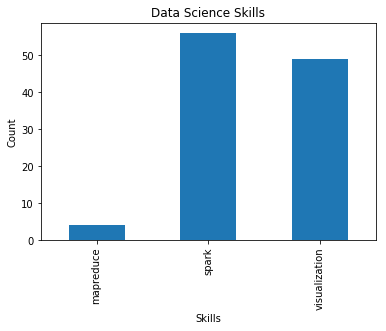

In [30]:
pseries = pd.Series(skill_set)
pseries.sort_values(ascending=False)

pseries.plot(kind = 'bar')
## set the title to Score Comparison
plt.title('Data Science Skills')
## set the x label
plt.xlabel('Skills')
## set the y label
plt.ylabel('Count')
## show the plot
plt.show()

**Question 7**:
- rerun the code to find the counts of the 3 data science skills on the first 200 job ads

## Lab 3.B: Data analysis of job skills
In the first part of the lab, you created `skill_set` dictionary that counts occurences of 3 important data science skills. In this part of the lab we are asking you to create pandas `DataFrame` object as a table whose rows correspond to individual ads and columns correspond to important information about the ads and skills mentioned on those pages. Let us call the table `job_ads`. Process the first 1,000 data science ads, so your table should have 1,000 rows. For each ad, you will have to create the following columns:
- job title
- company name
- job location
- skill 1
- skill 2
- ...
- skill 20

Job title, company name, and job locations will be readable from the Indeed.com page. We are asking you to list 20 skills, instead of only 3 in the code above ('mapreduce', 'spark', 'visualization'). You will need to find another 17 words that are commonly used in data science job ads. To do it, please explore the content of at least 10 ads.

Once you creat your `job_ads` table, please preform EDA of the table, in a similar way you did in Lab 2: provide code and a 2-page document that summarizes interesitng insights about the first 1,000 data science jobs.

**Deliverables**:
- the modified Lab 4 .ipynb file that contains all the answers to the questions
- a 2-page documents presenting the results of your EDA of the `job_ads` data

In [113]:
#Find first 1000 jobs
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []
title = []
company = []
location = []
j = 0

for i in range(num_pages): #do range(num_pages) if you want them all
    if j >= 1000:
        break
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    html_page = urllib2.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')
    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if not jp.get('class') is None 
                    and ''.join(jp.get('class')) =="rowresult"]
    job_ids = [jp.get('data-jk') for jp in job_postings]

    #get job titles, companies, and locations
    for job in job_postings:
        title.append(job.find('a').get('title'))
        company_area = job.find('span', {'class': 'company'})
        if company_area.a == None: #some company names are in a link <a> tag
            company.append(company_area.contents[0].encode('utf-8').strip())
        else:
            company.append(company_area.a.contents[0].encode('utf-8').strip())
        location.append(str(job.find('span', {'class': 'location'}).contents[0]))
                       
    # go after each link
    for id in job_ids:
        if j >= 1000:
            break
        job_links.append(base_url + '/rc/clk?jk=' + id)
        j = j + 1
    time.sleep(1)

    

In [114]:
skill_set = {'mapreduce':[], 'spark':[], 'visualization':[], 'python': [], 'distributed': [],
             'clustering': [], 'regression': [], 'big data': [], 'unstructured': [], 'structured': [],
             'sql': [], 'optimization': [], 'machine learning': [], 'statistics': [], 'nlp' :[],
             'team': [], 'modeling': [], 'leadership': [], 'communication': [], 'agile': []}

counter = 0
for link in job_links:
    counter +=1  
    
    #can't get job title/location/company here since indeed sometimes redirects to companies own page which are all unique
    try:
        html_page = urllib2.urlopen(link).read()
    except urllib2.HTTPError:
#         print "HTTPError:"
        continue
    except urllib2.URLError:
#         print "URLError:"
        continue
    except socket.error as error:
        print "Connection closed"
        continue

    html_text = re.sub("[^a-z.+3]"," ", html_page.lower()) # replace all but the listed characters
        
    for key in skill_set.keys():
        if key in html_text:  
            skill_set[key].append(1)
        else:
            skill_set[key].append(0)
    

HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
URLError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
URLError:
HTTPError:
URLError:
HTTPError:
HTTPError:
HTTPError:
URLError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
URLError:
URLError:
HTTPError:
URLError:
HTTPError:
URLError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
URLError:
HTTPError:
URLError:
HTTPError:
HTTPError:
HTTPError:
URLError:
HTTPError:
HTTPError:

In [189]:
# job_info = pd.DataFrame({'title': title, 'company': company, 'location': location})
short_title = title[:len(skill_set['mapreduce'])] #need to shorten since http errors reduce number of jobs parsed for skills
short_location = location[:len(skill_set['mapreduce'])]
short_company = company[:len(skill_set['mapreduce'])]
job_ads = pd.DataFrame(skill_set)
job_ads['title'] = short_title
job_ads['company'] = short_company
job_ads['location'] = short_location

In [257]:
cols = ['title', 'company', 'location', 'mapreduce', 'spark', 'visualization', 'python', 
        'clustering', 'regression', 'big data', 'unstructured', 'structured', 'distributed',
        'sql', 'optimization', 'machine learning', 'statistics', 'nlp',
        'team', 'modeling', 'leadership', 'communication', 'agile'
        ]
job_ads = job_ads[cols]
job_ads.head()

,title,company,location,mapreduce,spark,visualization,python,clustering,regression,big data,...,sql,optimization,machine learning,statistics,nlp,team,modeling,leadership,communication,agile
0,Data Scientist with NLP focus,Walmart eCommerce,"Sunnyvale, CA",0,1,0,0,0,0,1,...,1,1,0,1,0,1,1,1,1,0
1,Data Scientists,Bartech Group,"Dearborn, MI",0,0,0,1,1,1,0,...,0,0,1,1,1,1,0,0,0,0
2,Machine Learning Engineer,AnswerIQ,"Bellevue, WA",0,0,1,1,0,0,1,...,0,0,1,1,0,1,1,0,1,0
3,Data Scientist I,Children's Hospital of Philadelphia,"Philadelphia, PA 19146",0,1,1,1,0,0,0,...,1,0,1,1,0,1,0,0,0,0
4,Data Scientist - Reliability,Tesla,"Palo Alto, CA",0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


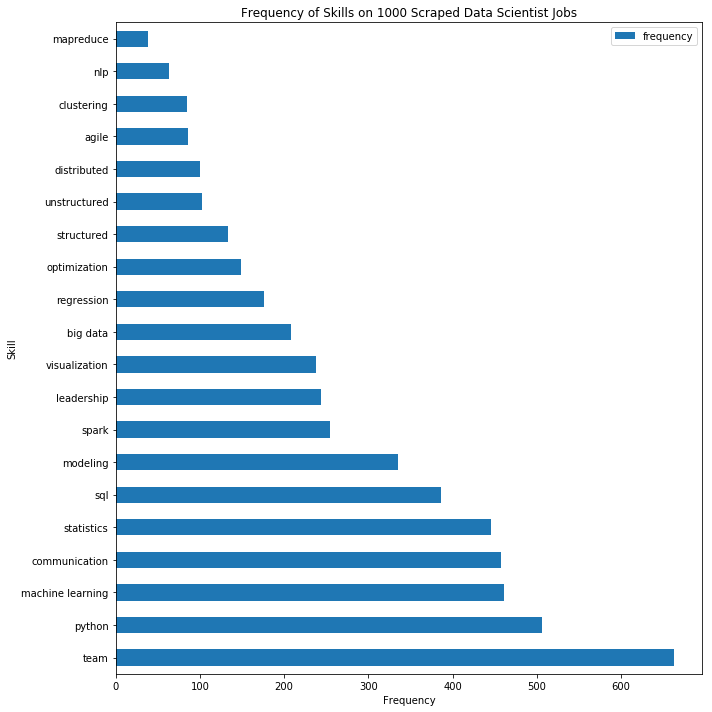

In [370]:
import matplotlib.pyplot as plt

skill_cols = cols[3:]
job_ads.iloc[:, 3:].values #no name/company/location


skill_set_sum = {}
for skill in skill_set:
    skill_set_sum[skill] = sum(skill_set[skill])

skills_df = pd.DataFrame(skill_set_sum.items(), columns = ['skill', 'frequency'])
skills_df = skills_df.sort_values(by = ['frequency'], ascending = False)
ax = skills_df.plot(x='skill', y='frequency', kind='barh', figsize = (10, 10))
ax.set_title('Frequency of Skills on 1000 Scraped Data Scientist Jobs')
ax.set_ylabel('Skill')
ax.set_xlabel('Frequency')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('skill frequency')

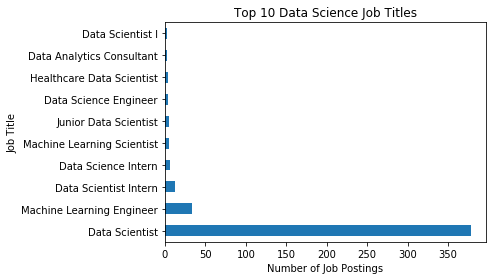

In [366]:
# print job_ads['location'].value_counts()
titles = pd.value_counts(job_ads['title'].values, sort=True)
ax = titles.head(10).plot.barh(title = 'Top 10 Data Science Job Titles', figsize = (7,4))
ax.set_xlabel('Number of Job Postings')
ax.set_ylabel('Job Title')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('top 10 job titles')

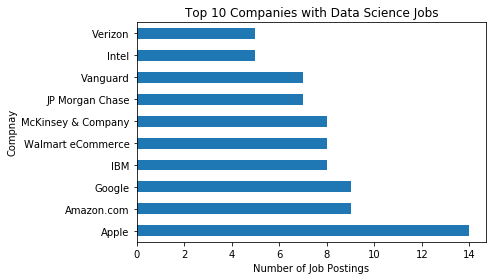

In [365]:
companies = pd.value_counts(job_ads['company'].values, sort=True)
ax = companies.head(10).plot.barh(title = 'Top 10 Companies with Data Science Jobs', figsize = (7,4))
ax.set_xlabel('Number of Job Postings')
ax.set_ylabel('Compnay')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('top 10 companies')

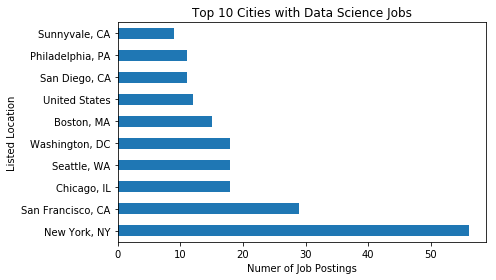

In [367]:
locations = pd.value_counts(job_ads['location'].values, sort=True)
ax = locations.head(10).plot.barh(title = 'Top 10 Cities with Data Science Jobs', figsize = (7, 4))
ax.set_xlabel('Numer of Job Postings')
ax.set_ylabel('Listed Location')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('top 10 locations')

In [376]:
job_ads[job_ads['location'] == 'Philadelphia, PA'].iloc[:, 3:].sum()

mapreduce           0
spark               3
visualization       4
python              7
clustering          2
regression          3
big data            3
unstructured        3
structured          3
distributed         2
sql                 4
optimization        4
machine learning    7
statistics          6
nlp                 1
team                9
modeling            4
leadership          3
communication       9
agile               1
dtype: int64

In [377]:
job_ads[job_ads['company'] == 'Apple'].iloc[:, 3:].sum()

mapreduce           1
spark               5
visualization       4
python              8
clustering          0
regression          4
big data            2
unstructured        3
structured          3
distributed         2
sql                 5
optimization        1
machine learning    7
statistics          6
nlp                 2
team                9
modeling            3
leadership          2
communication       5
agile               2
dtype: int64

In [340]:
gb = job_ads.groupby('location')
city_skills = pd.DataFrame()

for city in locations.head(10).index.values:
    city_skills[city] = gb.get_group(city).iloc[:, 3:].sum()
    
city_skills

,"New York, NY","San Francisco, CA","Chicago, IL","Seattle, WA","Washington, DC","Boston, MA",United States,"San Diego, CA","Philadelphia, PA","Sunnyvale, CA"
mapreduce,5,2,0,1,0,1,2,0,0,0
spark,22,11,3,5,6,3,4,5,3,3
visualization,14,13,5,7,5,5,2,3,4,1
python,30,18,9,10,14,12,8,7,7,4
clustering,2,1,2,3,1,0,2,2,2,1
regression,7,5,4,6,3,1,2,3,3,2
big data,16,11,2,6,6,7,4,3,3,2
unstructured,7,2,2,0,4,4,2,1,3,1
structured,10,3,2,1,6,4,3,1,3,1
distributed,6,3,5,2,3,2,1,0,2,0
